# S3 to Qdrant Cloud Pipeline using Unstructured Workflow Endpoint

This notebook demonstrates a complete end-to-end document processing pipeline using the **Unstructured Workflow Endpoint**. The pipeline processes PDF documents from URLs and stores the structured results in Qdrant Cloud, showcasing the power and flexibility of the Unstructured platform for enterprise document processing and vector search.

## What is the Unstructured Workflow Endpoint?

The **Unstructured Workflow Endpoint** is a powerful cloud-based platform that enables organizations to build sophisticated document processing pipelines without managing infrastructure. Key features include:

- **🔗 Source Connectors**: Connect to various data sources (S3, Azure Blob, Google Drive, etc.)
- **🎯 Destination Connectors**: Output processed data to databases, data warehouses, or vector stores
- **⚙️ Processing Nodes**: Modular components for partitioning, chunking, embedding, and more
- **🤖 AI-Powered Processing**: Leverage advanced models like Vision Language Models (VLMs) for intelligent document understanding
- **📊 Workflow Orchestration**: Chain multiple processing steps into sophisticated pipelines
- **🔄 Job Management**: Monitor, track, and manage processing jobs at scale

## Pipeline Architecture Overview

Our pipeline demonstrates a real-world RAG (Retrieval-Augmented Generation) preparation workflow:

```
PDF URLs → Download → S3 Upload → Unstructured Workflow Endpoint → Qdrant Cloud
                                        ↓
                                  [Partition] → [Chunk] → [Embed]
```

### Processing Steps Explained:

1. **📥 Document Acquisition**: Downloads PDF files from specified URLs to demonstrate batch processing
2. **☁️ Cloud Storage**: Uploads documents to Amazon S3, the source for our workflow
3. **🔌 Source Configuration**: Creates an S3 source connector that tells the API where to find documents
4. **🎯 Destination Setup**: Configures a Qdrant Cloud destination connector for storing processed results as vector points
5. **⚙️ Workflow Creation**: Builds a custom processing pipeline with three powerful nodes:
   - **🧠 VLM Partitioner**: Uses GPT-4o Vision to intelligently segment documents, understanding layout, tables, images, and text hierarchy
   - **✂️ Smart Chunker**: Breaks documents into semantically meaningful chunks based on document structure (titles, sections)
   - **🔢 Vector Embedder**: Generates high-quality embeddings using OpenAI's text-embedding-3-small for semantic search
6. **🚀 Execution & Monitoring**: Runs the workflow and provides real-time job monitoring with detailed status updates
7. **✅ Verification**: Validates that processed documents are correctly stored in Qdrant Cloud with proper vector structure

## Why Use Unstructured Workflow Endpoint?

- **🏗️ No Infrastructure Management**: Focus on your use case, not on managing servers or scaling
- **🎯 Production-Ready**: Built for enterprise scale with reliability and monitoring
- **🔧 Flexible Architecture**: Mix and match processing nodes to create custom workflows
- **📈 Scalable**: Process thousands of documents efficiently
- **🤖 AI-Native**: Leverage cutting-edge AI models for document understanding
- **🔗 Integration-Friendly**: Easy integration with existing data infrastructure

## Prerequisites

Before running this notebook, ensure you have:
- **Unstructured API key** (sign up at [unstructured.io](https://unstructured.io))
- **AWS credentials** with S3 read/write permissions
- **Qdrant Cloud account** with a cluster and API key
- **Python environment** with required packages installed

## 🚀 Step 1: Connect Your S3 Bucket in Unstructured

### 🔑 Retrieve AWS Security Credentials
AWS provides instructions here: https://docs.aws.amazon.com/IAM/latest/UserGuide/security-creds-programmatic-access.html
Alternatively:
1. Navigate to the top bar in AWS and click your account ID in the top right.
2. Scroll down to Security Credentials

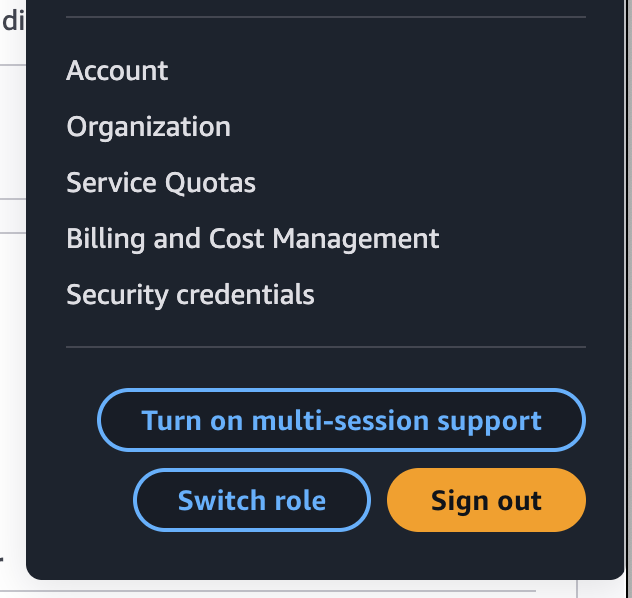

3. Scroll to the Access keys section and click Create access key

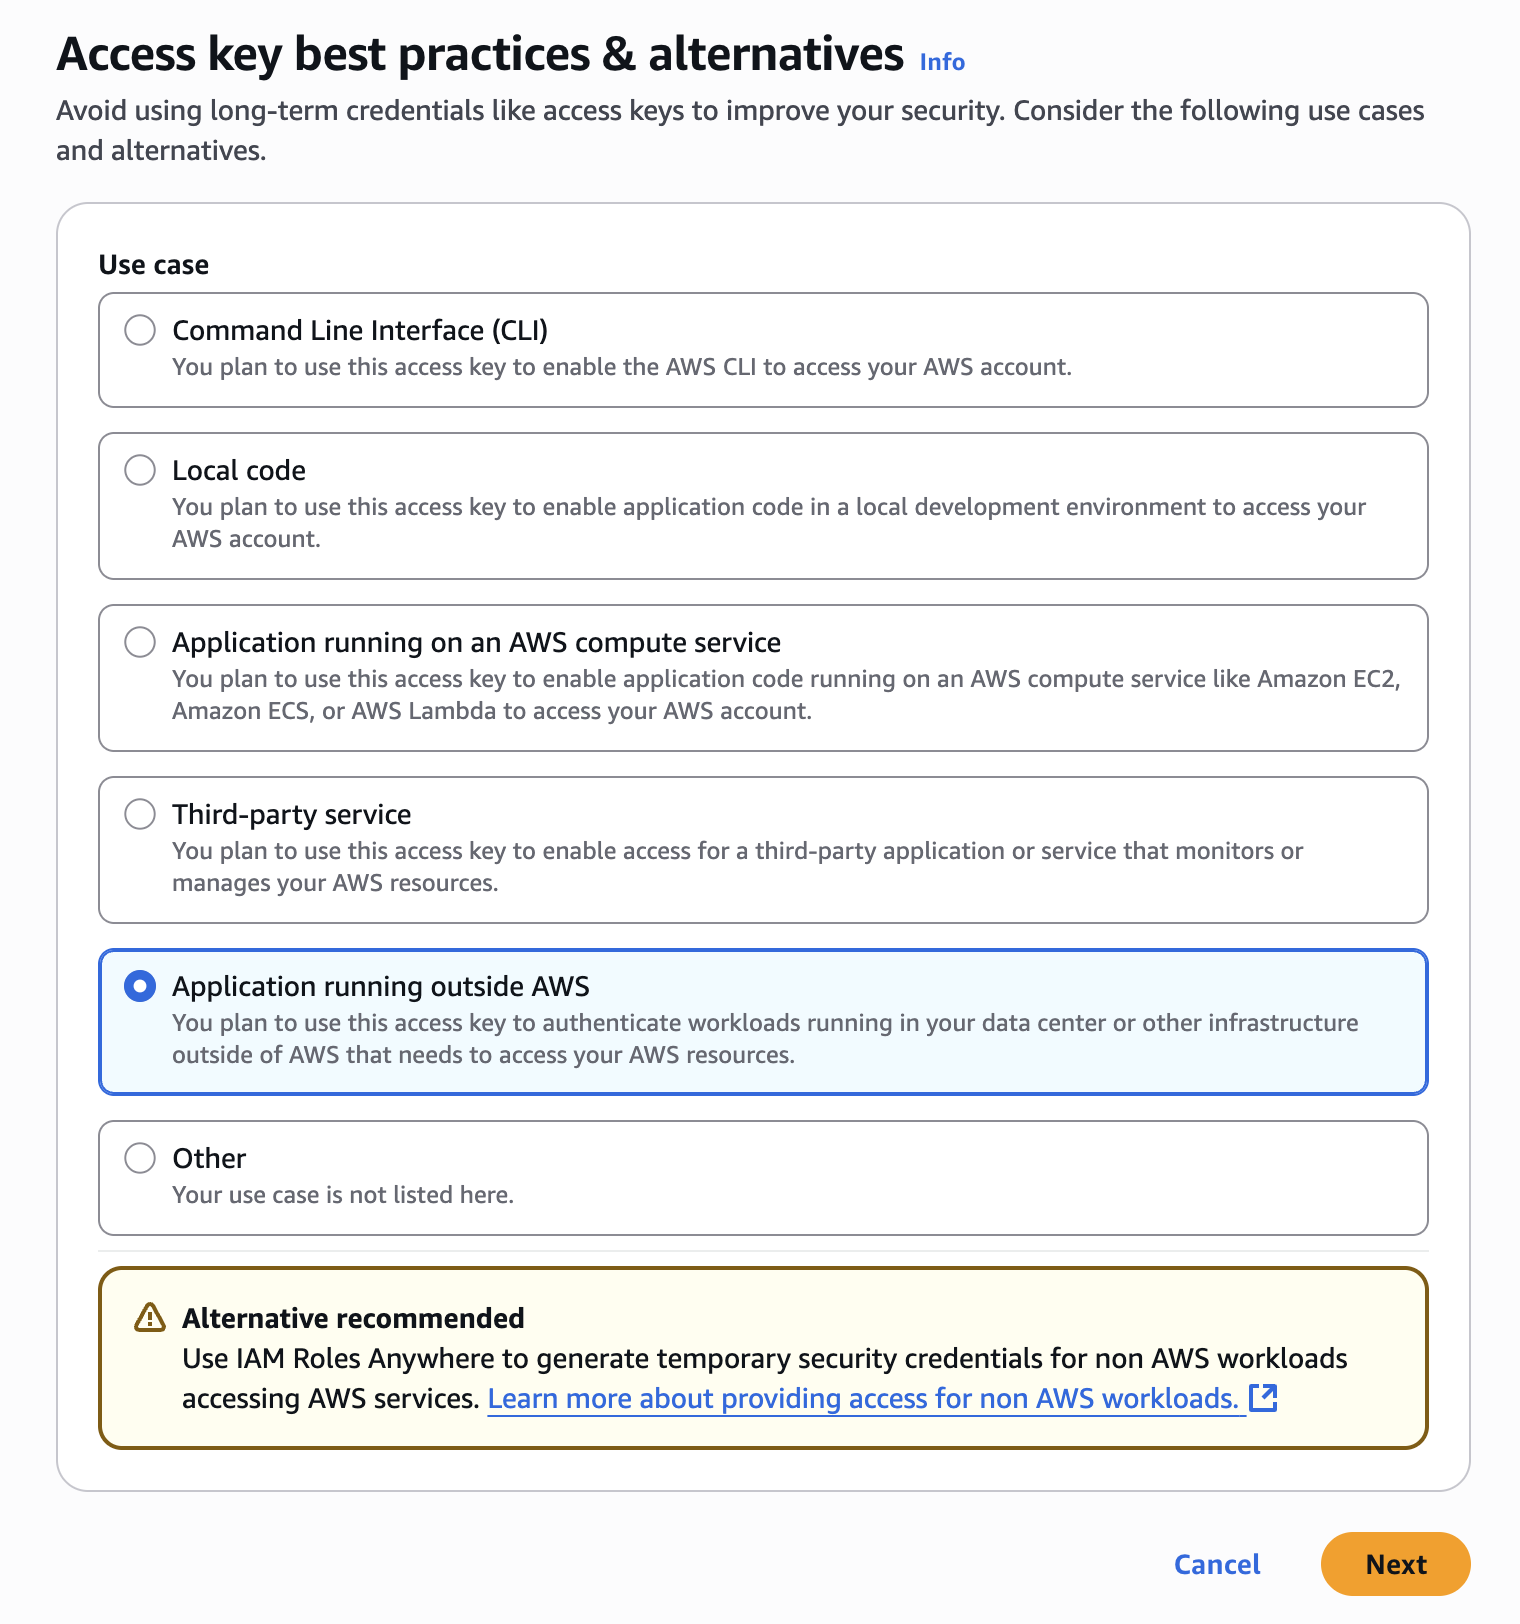

4. You'll receive an Access Key ID and Secret Access Key. These demo credentials are deactivated:

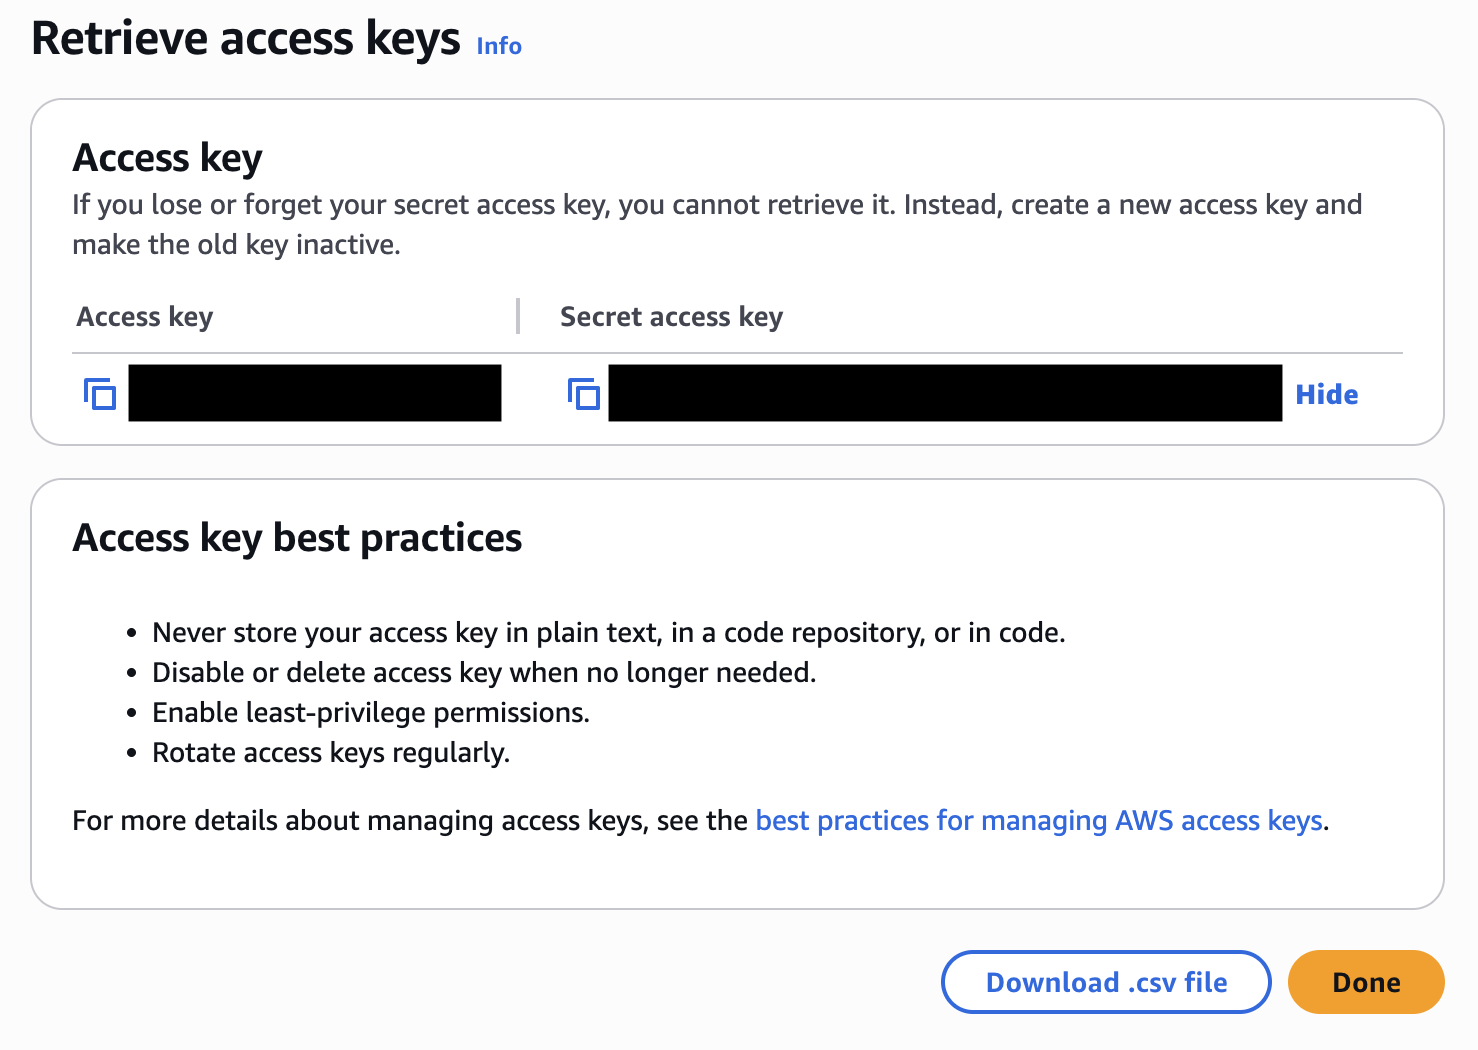
5. Click Download .csv file to keep a local copy of the keys for reference.

### 🪣 Create a New S3 Bucket
This bucket will contain your input PDFs.
1. In the AWS Console, go to Amazon S3 → Buckets, then click Create bucket
2. Use a name like nicks-demo-s3-bucket
3. Keep Block all public access checked
4. Leave all other settings as default
5. Click Create bucket
Then:
- Locate your new bucket in the list and click its name

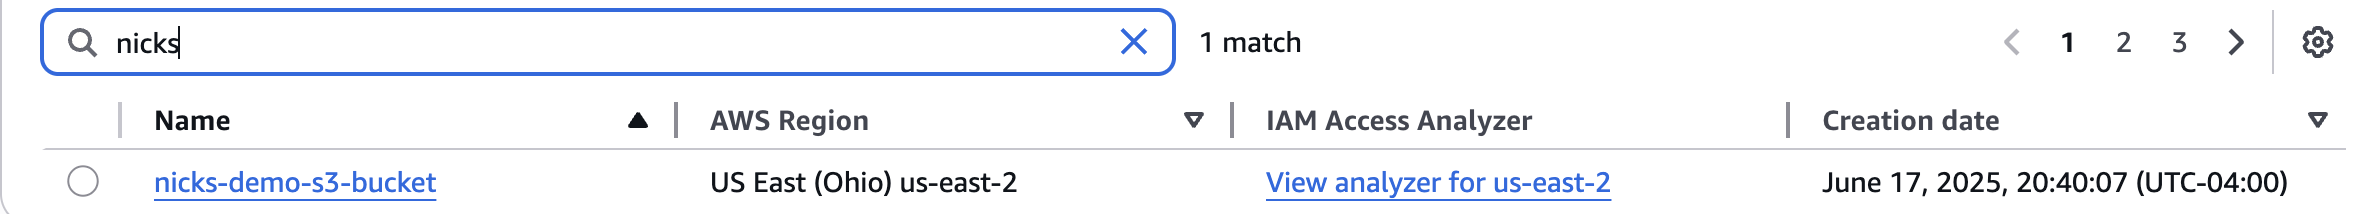

- Click the Upload button

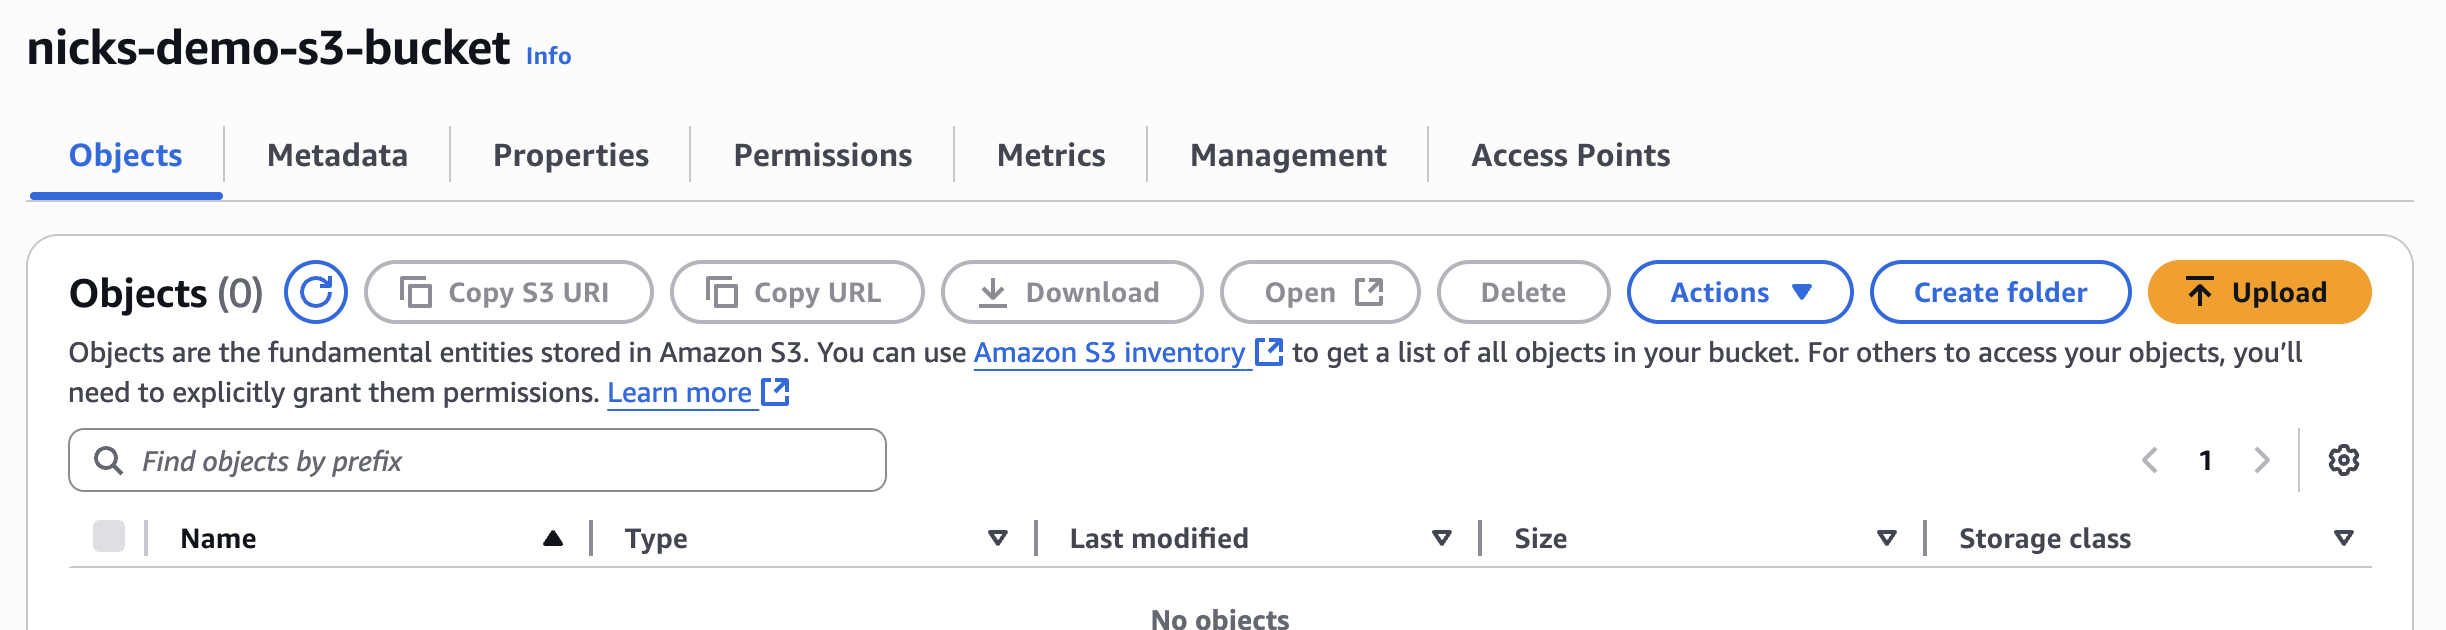

- Click Add files and select the PDF documents you want to upload

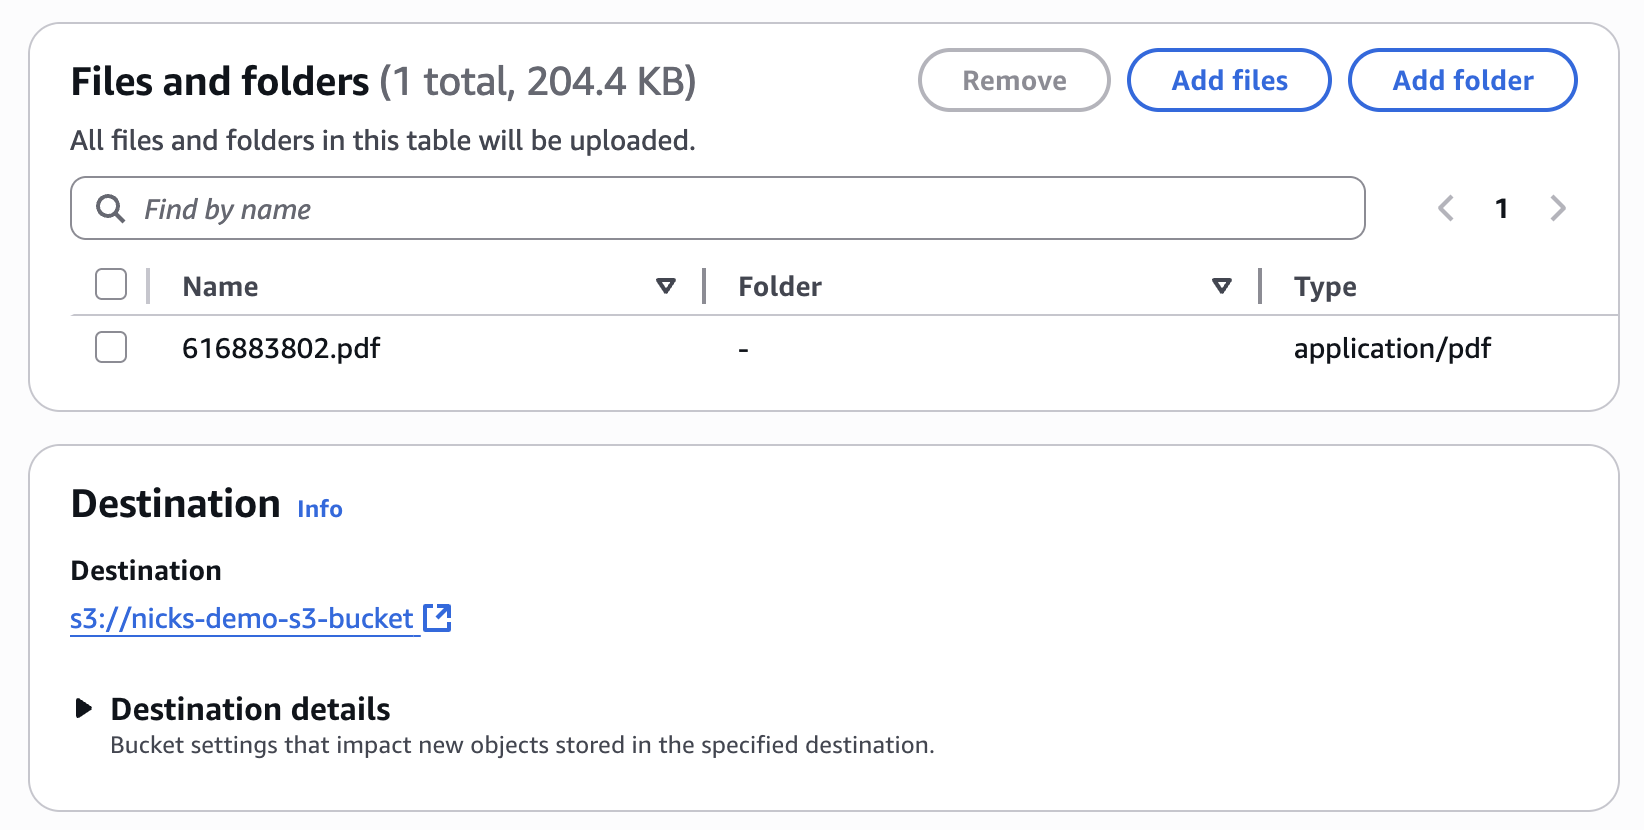

- Copy the full Destination URI (e.g., s3://nicks-demo-s3-bucket)
- Scroll down and click Upload

### 🔒 Set S3 Bucket Permissions
1. Navigate to your bucket
2. Select the Permissions tab at the top


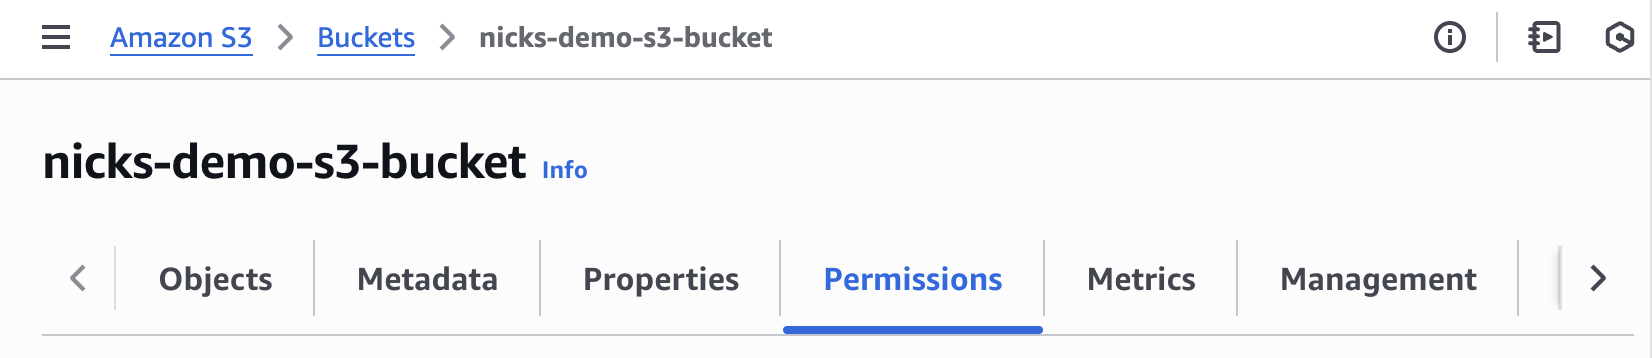


Note: If you're using access keys tied to an account with full S3 read/write permissions, you can leave the bucket policy blank.

## 📦 Step 3: Set Up Qdrant

### 🔧 Create a Qdrant Cluster
1. Sign up at Qdrant.com
2. On the landing page, click Create Cluster
3. Name the cluster, choose Amazon Web Services as the cloud provider, and leave the region as default

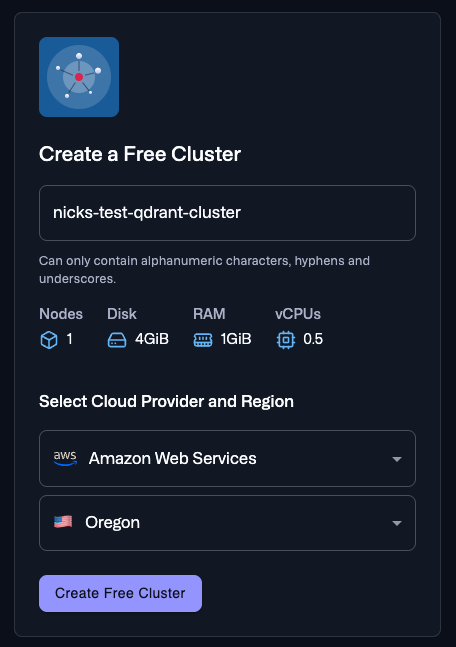

4. When prompted, copy the API Key and Qdrant URL — this is the only time they'll be shown

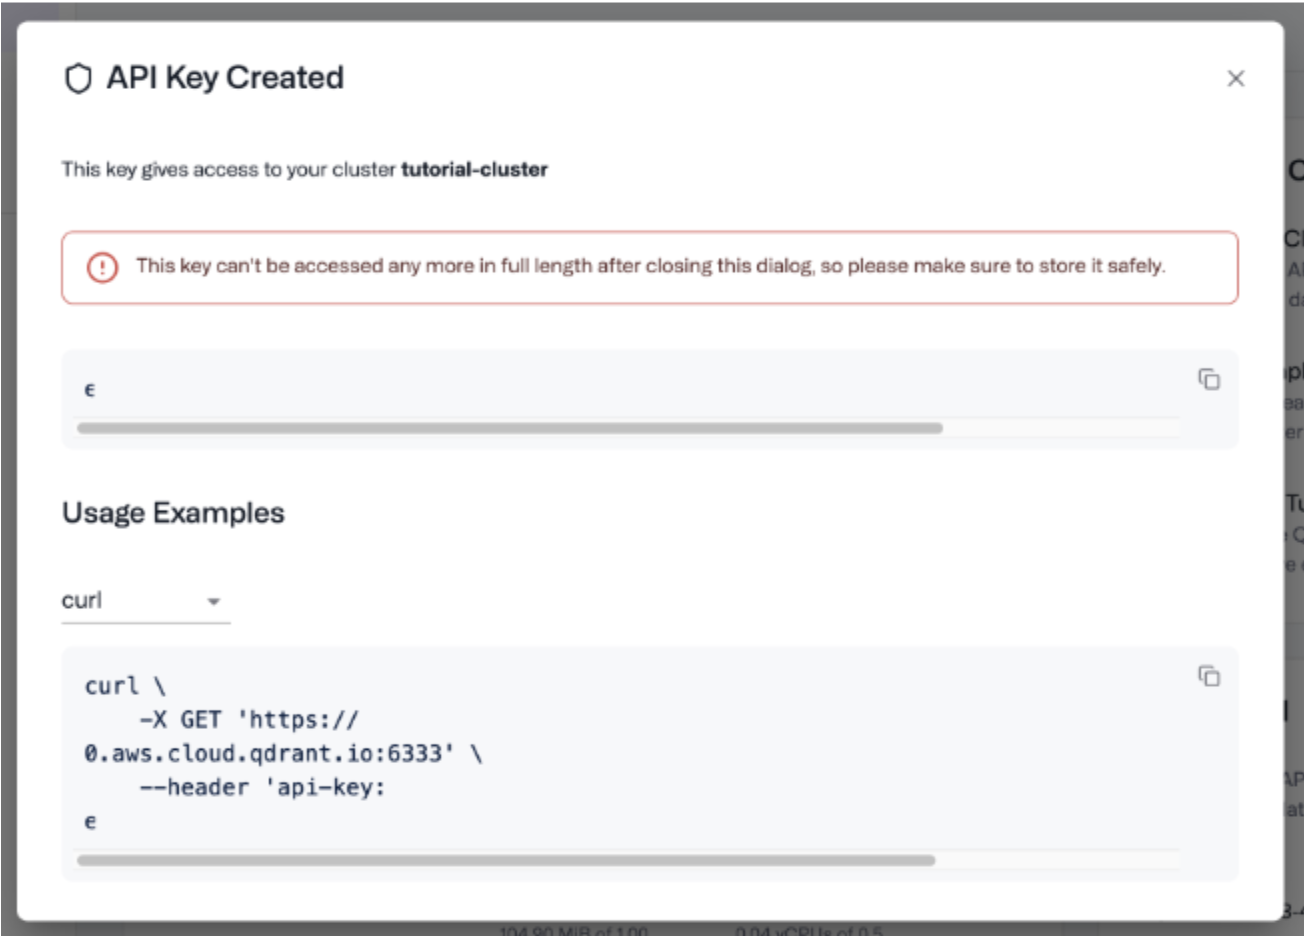

5. Wait for the cluster status to show Healthy

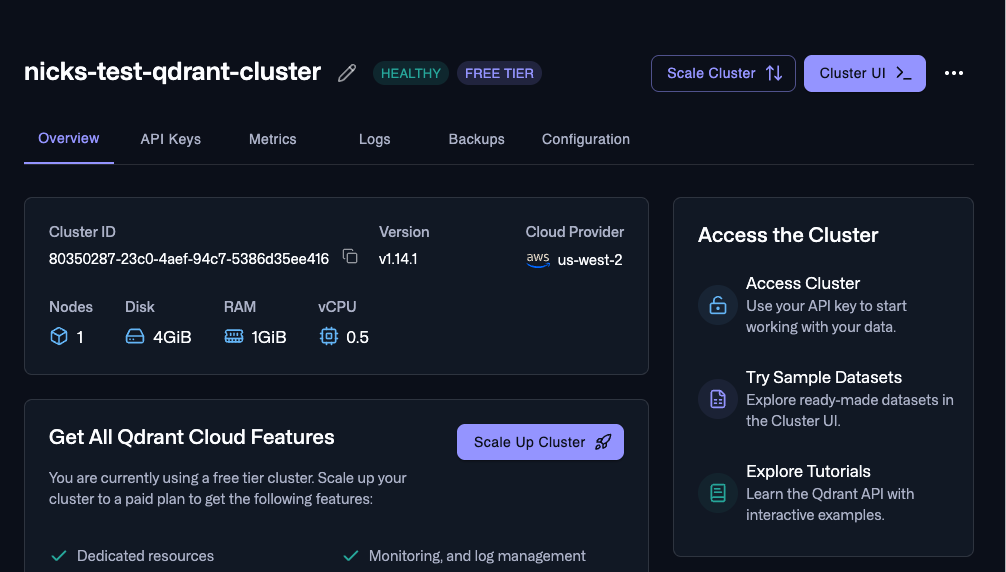

6. Click Access Cluster

**Note**: The Qdrant collection will be automatically created when you run the notebook pipeline in the steps below. No manual collection setup is required. After running the pipeline, in the Qdrant UI you can access the collection to see its contents. From the left sidebar, click Collections.

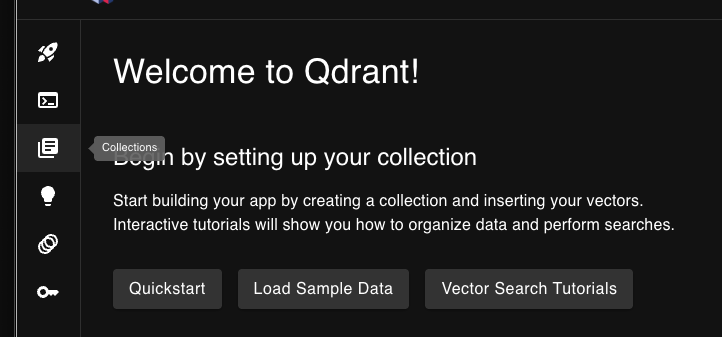



## Import Required Libraries

In [5]:
%pip install boto3 python-dotenv qdrant-client unstructured-client requests certifi

In [6]:
import os
import sys
import time
import uuid
import requests
import boto3
import json
from pathlib import Path
from dotenv import load_dotenv
from qdrant_client import QdrantClient, models
from unstructured_client import UnstructuredClient
from unstructured_client.models.operations import (
    CreateSourceRequest,
    CreateDestinationRequest
)
from unstructured_client.models.shared import (
    CreateSourceConnector,
    SourceConnectorType,
    S3SourceConnectorConfigInput,
    CreateDestinationConnector,
    DestinationConnectorType,
    QdrantCloudDestinationConnectorConfigInput,
    WorkflowNode,
    WorkflowType,
    Schedule
)

## Configuration and Environment Setup

This section loads environment variables and initializes the necessary clients for our pipeline.
We'll validate all required credentials before proceeding with the workflow.

In [7]:
import sys

# Configuration - Set these explicitly
AWS_ACCESS_KEY_ID = "your-access-key-id"
AWS_SECRET_ACCESS_KEY = "your-secret-access-key"
AWS_REGION = "your-region"
S3_BUCKET = "your-s3-bucket-name"
UNSTRUCTURED_API_KEY = "your-unstructured-api-key"
UNSTRUCTURED_API_URL = "https://platform.unstructuredapp.io/api/v1" # Only modify this if your endpoint URL is different than the default. For more information, please see https://docs.unstructured.io/api-reference/troubleshooting/api-key-url
QDRANT_URL = "your-qdrant-cloud-url"
QDRANT_API_KEY = "your-qdrant-api-key"
QDRANT_COLLECTION = "workflow_documents"
AWS_SESSION_TOKEN = ""  # Optional: provide if using temporary credentials

# Validation
REQUIRED_VARS = {
    "AWS_ACCESS_KEY_ID": AWS_ACCESS_KEY_ID,
    "AWS_SECRET_ACCESS_KEY": AWS_SECRET_ACCESS_KEY,
    "AWS_REGION": AWS_REGION,
    "S3_BUCKET": S3_BUCKET,
    "UNSTRUCTURED_API_KEY": UNSTRUCTURED_API_KEY,
    "UNSTRUCTURED_API_URL": UNSTRUCTURED_API_URL,
    "QDRANT_URL": QDRANT_URL,
    "QDRANT_API_KEY": QDRANT_API_KEY,
    "QDRANT_COLLECTION": QDRANT_COLLECTION
}

missing_vars = [key for key, value in REQUIRED_VARS.items() if not value]
if missing_vars:
    print(f"❌ Missing required configuration values: {', '.join(missing_vars)}")
    print("Please update the script with the required information.")
    sys.exit(1)

print("✅ All required configuration values set successfully")

✅ All required configuration values set successfully


### Initialize Clients and Test Connections

In [8]:
# Create downloads directory for temporary file storage
DOWNLOADS_DIR = "downloads"
Path(DOWNLOADS_DIR).mkdir(exist_ok=True)

# Initialize Unstructured client
print("🔧 Initializing Unstructured client...")
unstructured_client = UnstructuredClient(
    api_key_auth=UNSTRUCTURED_API_KEY,
    server_url=UNSTRUCTURED_API_URL
    )

# Helper function to pretty print API responses
def pretty_print_model(response_model):
    """Pretty print model responses for better readability"""
    print(response_model.model_dump_json(indent=4))

# Initialize Amazon S3 client
print("🔧 Initializing Amazon S3 client...")
s3 = boto3.client(
    "s3",
    region_name=AWS_REGION,
    aws_access_key_id=AWS_ACCESS_KEY_ID,
    aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
)

# Test Qdrant connection to ensure it's accessible
print("🔧 Testing Qdrant connection...")
try:
    qdrant_client = QdrantClient(
        url=QDRANT_URL,
        api_key=QDRANT_API_KEY
    )
    # Recommended way to test connection
    collections = qdrant_client.get_collections()
    print("✅ Qdrant connection successful")
    print(f"  📁 Available collections: {[c.name for c in collections.collections]}")
    qdrant_client.close()
except Exception as e:
    print(f"❌ Qdrant connection failed: {e}")
    print("Please check your QDRANT_URL and QDRANT_API_KEY")
    sys.exit(1)

print("🎉 All clients initialized and connections tested successfully!")

🔧 Initializing Unstructured client...
🔧 Initializing Amazon S3 client...
🔧 Testing Qdrant connection...
✅ Qdrant connection successful
  📁 Available collections: ['example-image-transformations', 'my-test-collection', 'sample-qdrant-connector-output']
🎉 All clients initialized and connections tested successfully!


## Qdrant Collection Management

This section handles Qdrant collection creation and management. Qdrant requires collections
to exist before data can be written to them, so we'll create the collection with proper
vector configuration based on the embedding model we're using.

In [9]:
def create_qdrant_collection():
    """
    Create a Qdrant collection for storing document embeddings.

    This function creates a collection configured for the embeddings generated by
    OpenAI's text-embedding-3-small model, which produces 1536-dimensional vectors.

    Returns:
        bool: True if collection was created or already exists, False if failed
    """
    try:
        print("🔧 Creating Qdrant collection...")

        client = QdrantClient(
            url=QDRANT_URL,
            api_key=QDRANT_API_KEY
        )

        # Check if collection already exists
        try:
            collection_info = client.get_collection(collection_name=QDRANT_COLLECTION)
            print(f"  ✅ Collection '{QDRANT_COLLECTION}' already exists")
            print(f"  📊 Collection status: {collection_info.status}")
            client.close()
            return True
        except Exception:
            # Collection doesn't exist, create it
            pass

        # Create collection with vector configuration
        # text-embedding-3-small produces 1536-dimensional vectors
        client.create_collection(
            collection_name=QDRANT_COLLECTION,
            vectors_config=models.VectorParams(
                size=1536,  # Dimension for text-embedding-3-small
                distance=models.Distance.COSINE  # Cosine similarity for semantic search
            )
        )

        # Verify collection was created
        collection_info = client.get_collection(collection_name=QDRANT_COLLECTION)
        print(f"  ✅ Created collection '{QDRANT_COLLECTION}' successfully")
        print(f"  📊 Collection status: {collection_info.status}")
        print(f"  🔢 Vector dimension: 1536 (text-embedding-3-small)")
        print(f"  📏 Distance metric: COSINE")

        client.close()
        return True

    except Exception as e:
        print(f"  ❌ Error creating Qdrant collection: {e}")
        if 'client' in locals():
            client.close()
        return False

## Utility Functions

This section defines the core functions that power our document processing pipeline. Each function serves a specific purpose in the workflow and demonstrates different aspects of the Unstructured Workflow Endpoint.

### Function Categories:

1. **📥 Document Management Functions**
   - `download_pdf()`: Downloads PDF files from URLs with robust error handling
   - `upload_to_s3()`: Uploads files to S3 with proper organization and validation

2. **🔌 Connector Management Functions**
   - `create_s3_source_connector()`: Creates and configures S3 source connectors
   - `create_qdrant_destination_connector()`: Sets up Qdrant Cloud destination connectors

3. **⚙️ Workflow Orchestration Functions**
   - `create_workflow()`: Builds custom processing workflows with multiple nodes
   - `run_workflow()`: Executes workflows and returns job information

4. **📊 Monitoring and Verification Functions**
   - `poll_job_status()`: Monitors job progress with real-time status updates
   - `verify_qdrant_results()`: Validates processed data in the destination database

These functions showcase the flexibility and power of the Unstructured Workflow Endpoint, demonstrating how to build production-ready document processing pipelines.

### Document Management Functions

These functions handle the initial stages of our pipeline: acquiring documents and preparing them for processing.

In [10]:
def download_pdf(url):
    """Download a PDF from a given URL with robust error handling."""
    try:
        filename = url.split("/")[-1]
        if not filename.endswith('.pdf'):
            filename += '.pdf'

        local_path = os.path.join(DOWNLOADS_DIR, filename)

        print(f"  📥 Downloading {filename}...")
        response = requests.get(url, timeout=30, stream=True)
        response.raise_for_status()

        # Validate content type
        content_type = response.headers.get('content-type', '').lower()
        if 'pdf' not in content_type and 'application/octet-stream' not in content_type:
            print(f"  ⚠️ Warning: Expected PDF but got content-type: {content_type}")

        with open(local_path, "wb") as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)

        # Verify download success
        if not os.path.exists(local_path) or os.path.getsize(local_path) == 0:
            print(f"  ❌ Downloaded file is empty or doesn't exist: {filename}")
            return None, None

        file_size = os.path.getsize(local_path)
        print(f"  ✅ Downloaded {filename} ({file_size:,} bytes)")
        return filename, local_path

    except Exception as e:
        print(f"  ❌ Error downloading {url}: {e}")
        return None, None

def upload_to_s3(local_path, filename):
    """Upload a file to S3 with error handling."""
    try:
        s3_key = f"workflow-docs/pdf/{filename}"

        if not os.path.exists(local_path):
            print(f"  ❌ Local file not found: {local_path}")
            return None

        file_size = os.path.getsize(local_path)
        s3.upload_file(local_path, S3_BUCKET, s3_key)
        print(f"  ✅ Uploaded to S3: s3://{S3_BUCKET}/{s3_key} ({file_size:,} bytes)")
        return s3_key

    except Exception as e:
        print(f"  ❌ Error uploading {filename} to S3: {e}")
        return None

### Connector Management Functions

**Source and Destination Connectors** are fundamental components of the Unstructured Workflow Endpoint. They define where your data comes from and where processed results go.

#### Understanding Connectors:
- **Source Connectors**: Tell the API where to find your documents (S3, Azure Blob, Google Drive, etc.)
- **Destination Connectors**: Define where processed data should be stored (Qdrant Cloud, Snowflake, Pinecone, etc.)
- **Reusability**: Once created, connectors can be reused across multiple workflows
- **Security**: Credentials are securely stored and managed by the Unstructured platform, which is SOC 2 Type II, and HIPAA compliant, ensuring industry-standard protections for confidentiality, integrity, and availability.

In [11]:
def create_s3_source_connector():
    """
    Create an S3 source connector for the Unstructured Workflow Endpoint.

    This function demonstrates how to configure the API to read documents from Amazon S3.
    The connector will scan the specified S3 path for documents to process.

    Key Configuration Options:
    - remote_url: S3 path where documents are stored
    - recursive: Whether to scan subdirectories
    - credentials: AWS access keys for authentication
    - region: AWS region for the S3 bucket

    Returns:
        str: Source connector ID if successful, None if failed
    """
    try:
        print("🔗 Creating S3 source connector...")

        response = unstructured_client.sources.create_source(
            request=CreateSourceRequest(
                create_source_connector=CreateSourceConnector(
                    name=f"s3_source_connector_{int(time.time())}",  # Unique name with timestamp
                    type=SourceConnectorType.S3,  # Specify S3 as the source type
                    config=S3SourceConnectorConfigInput(
                        remote_url=f"s3://{S3_BUCKET}/workflow-docs/",  # S3 path to scan
                        recursive=True,  # Scan subdirectories
                        key=AWS_ACCESS_KEY_ID,  # AWS credentials
                        secret=AWS_SECRET_ACCESS_KEY,
                        region=AWS_REGION  # AWS region
                    )
                )
            )
        )

        source_id = response.source_connector_information.id
        print(f"  ✅ Created S3 source connector: {source_id}")
        return source_id

    except Exception as e:
        print(f"  ❌ Error creating S3 source connector: {e}")
        return None

def create_qdrant_destination_connector():
    """
    Create a Qdrant Cloud destination connector for the Unstructured Workflow Endpoint.

    This function demonstrates how to configure the API to store processed documents
    in Qdrant Cloud. The connector handles the structured output from the workflow nodes
    and stores them as vector points in the Qdrant collection.

    Key Configuration Options:
    - url: Qdrant Cloud cluster URL
    - collection_name: Target collection name
    - api_key: Qdrant API key for authentication
    - batch_size: Number of documents to write in each batch (optimizes performance)

    Returns:
        str: Destination connector ID if successful, None if failed
    """
    try:
        print("🔗 Creating Qdrant Cloud destination connector...")

        response = unstructured_client.destinations.create_destination(
            request=CreateDestinationRequest(
                create_destination_connector=CreateDestinationConnector(
                    name=f"qdrant_dest_connector_{int(time.time())}",  # Unique name with timestamp
                    type=DestinationConnectorType.QDRANT_CLOUD,  # Specify Qdrant Cloud as destination
                    config=QdrantCloudDestinationConnectorConfigInput(
                        url=QDRANT_URL,  # Qdrant Cloud cluster URL
                        collection_name=QDRANT_COLLECTION,  # Target collection
                        api_key=QDRANT_API_KEY,  # Qdrant API key
                        batch_size=50  # Batch size for optimal performance
                    )
                )
            )
        )

        destination_id = response.destination_connector_information.id
        print(f"  ✅ Created Qdrant Cloud destination connector: {destination_id}")
        return destination_id

    except Exception as e:
        print(f"  ❌ Error creating Qdrant Cloud destination connector: {e}")
        return None

### Workflow Orchestration Functions

**Workflows** are the heart of the Unstructured platform. They define how documents are processed through a series of connected nodes, each performing specific operations on the data.

#### Understanding Workflow Nodes:
- **Partition Nodes**: Break documents into logical elements (paragraphs, tables, images)
- **Chunk Nodes**: Split large elements into smaller, manageable pieces
- **Embed Nodes**: Generate vector embeddings for semantic search
- **Enrichment Nodes**: Apply custom transformations to the data such as summarization of text, images, and tables

In [12]:
def create_workflow(source_id, destination_id):
    """
    Create a sophisticated document processing workflow using the Unstructured Workflow Endpoint.

    This function demonstrates the power of the platform by creating a three-stage pipeline
    that transforms raw PDFs into searchable, embedded document chunks ready for RAG applications.

    Workflow Architecture:
    PDF → [VLM Partition] → [Smart Chunk] → [Vector Embed] → Qdrant Cloud

    Returns:
        str: Workflow ID if successful, None if failed
    """
    try:
        print("⚙️ Creating advanced document processing workflow...")

        # 🧠 STAGE 1: VLM Partitioner Node
        # Uses GPT-4o Vision to intelligently understand document structure
        partition_node = WorkflowNode(
            name="VLM_Partitioner",
            subtype="vlm",  # Vision Language Model partitioning
            type="partition",
            settings={
                "provider": "openai",  # Use OpenAI's models
                "model": "gpt-4o",     # GPT-4o with vision capabilities
            }
        )
        print("  🧠 Configured VLM Partitioner: GPT-4o will analyze document layout, tables, and structure")

        # ✂️ STAGE 2: Smart Chunker Node
        # Breaks documents into semantically meaningful pieces based on titles/sections
        chunk_node = WorkflowNode(
            name='Smart_Chunker',
            subtype='chunk_by_title',  # Chunk based on document structure
            type="chunk",
            settings={
                'new_after_n_chars': 1500,    # Start new chunk after 1500 characters
                'max_characters': 2048,       # Maximum chunk size (optimal for embeddings)
                'overlap': 0                  # No overlap between chunks
            }
        )
        print("  ✂️ Configured Smart Chunker: Will create 1500-2048 character chunks based on document structure")

        # 🔢 STAGE 3: Vector Embedder Node
        # Generates high-quality embeddings for semantic search and RAG
        embedder_node = WorkflowNode(
            name='Vector_Embedder',
            subtype='openai',  # Use OpenAI's embedding models
            type="embed",
            settings={
                'model_name': 'text-embedding-3-small'  # Latest OpenAI embedding model
            }
        )
        print("  🔢 Configured Vector Embedder: Will generate embeddings using text-embedding-3-small")

        # 🔗 Create the complete workflow
        response = unstructured_client.workflows.create_workflow(
            request={
                "create_workflow": {
                    "name": f"S3-to-Qdrant-RAG-Pipeline_{int(time.time())}",
                    "source_id": source_id,
                    "destination_id": destination_id,
                    "workflow_type": WorkflowType.CUSTOM,  # Custom workflow with our specific nodes
                    "workflow_nodes": [
                        partition_node,  # Process documents with VLM
                        chunk_node,     # Break into manageable pieces
                        embedder_node   # Generate vector embeddings
                    ],
                }
            }
        )

        print("  📊 Workflow created successfully! Here's the configuration:")
        pretty_print_model(response.workflow_information)

        workflow_id = response.workflow_information.id
        print(f"  ✅ Workflow ID: {workflow_id}")
        print(f"  🎯 This workflow will process documents through: VLM Partition → Smart Chunk → Vector Embed")
        return workflow_id

    except Exception as e:
        print(f"  ❌ Error creating workflow: {e}")
        return None

### Job Management and Monitoring Functions

The Unstructured Workflow Endpoint provides comprehensive job management capabilities, allowing you to monitor progress, handle failures, and track processing statistics in real-time.

In [13]:
def run_workflow(workflow_id):
    """Run the workflow and return job information."""
    try:
        print("🚀 Running workflow...")

        res = unstructured_client.workflows.run_workflow(
            request={
                "workflow_id": workflow_id,
            }
        )

        pretty_print_model(res.job_information)
        job_id = res.job_information.id
        print(f"  ✅ Started job: {job_id}")
        return job_id

    except Exception as e:
        print(f"  ❌ Error running workflow: {e}")
        return None

def poll_job_status(job_id, wait_time=30):
    """Poll job status until completion."""
    print(f"⏳ Polling job status (checking every {wait_time} seconds)...")

    while True:
        try:
            response = unstructured_client.jobs.get_job(
                request={
                    "job_id": job_id
                }
            )

            job = response.job_information
            status = job.status

            if status == "SCHEDULED":
                print(f"  📅 Job is scheduled, checking again in {wait_time} seconds...")
                time.sleep(wait_time)
            elif status == "IN_PROGRESS":
                print(f"  ⚙️ Job is in progress, checking again in {wait_time} seconds...")
                time.sleep(wait_time)
            elif status == "COMPLETED":
                print(f"  ✅ Job completed successfully!")
                return job
            elif status == "FAILED":
                print(f"  ❌ Job failed!")
                return job
            else:
                print(f"  ❓ Unknown job status: {status}")
                return job

        except Exception as e:
            print(f"  ❌ Error polling job status: {e}")
            time.sleep(wait_time)

def verify_qdrant_results():
    """Verify that documents were stored in Qdrant."""
    try:
        print("🔍 Verifying Qdrant results...")

        client = QdrantClient(
            url=QDRANT_URL,
            api_key=QDRANT_API_KEY
        )

        # Get collection info and count
        collection_info = client.get_collection(collection_name=QDRANT_COLLECTION)
        count = collection_info.points_count
        print(f"  📊 Total points in Qdrant: {count}")

        if count > 0:
            # Get a sample point to show structure
            points = client.scroll(
                collection_name=QDRANT_COLLECTION,
                limit=1,
                with_payload=True,
                with_vectors=False  # Don't retrieve vectors for display
            )[0]

            if points:
                sample_point = points[0]
                print(f"  📄 Sample point ID: {sample_point.id}")
                if sample_point.payload:
                    print(f"  📄 Sample payload keys: {list(sample_point.payload.keys())}")

        client.close()
        return count

    except Exception as e:
        print(f"  ❌ Error verifying Qdrant results: {e}")
        if 'client' in locals():
            client.close()
        return 0

## Main Pipeline Execution

This section contains the main pipeline logic that orchestrates all the steps:
1. Download PDFs and upload to S3
2. Create source and destination connectors
3. Create and run the workflow
4. Monitor job progress
5. Verify results in Qdrant Cloud

In [14]:
# List of PDF URLs to process
pdf_urls = [
    "https://core.ac.uk/download/616883802.pdf",
    # Add more URLs as needed
]

print("🚀 Starting S3 to Qdrant Cloud Pipeline using Unstructured Workflow Endpoint")
print("=" * 70)

🚀 Starting S3 to Qdrant Cloud Pipeline using Unstructured Workflow Endpoint


### Step 1: Download and Upload PDFs to S3

In [15]:
# Step 1: Download and upload PDFs to S3
print("\n📥 Downloading and uploading PDFs to S3")
uploaded_files = []

for url in pdf_urls:
    print(f"\n📄 Processing: {url}")
    filename, local_path = download_pdf(url)

    if filename and local_path:
        s3_key = upload_to_s3(local_path, filename)
        if s3_key:
            uploaded_files.append(s3_key)
            # Clean up local file
            os.remove(local_path)
            print(f"  🗑️ Cleaned up local file: {local_path}")

if not uploaded_files:
    print("❌ No files were successfully uploaded to S3")
else:
    print(f"\n✅ Successfully uploaded {len(uploaded_files)} files to S3")


📥 Downloading and uploading PDFs to S3

📄 Processing: https://core.ac.uk/download/616883802.pdf
  📥 Downloading 616883802.pdf...
  ✅ Downloaded 616883802.pdf (209,313 bytes)
  ✅ Uploaded to S3: s3://nvannest-quickstart-sample-data/workflow-docs/pdf/616883802.pdf (209,313 bytes)
  🗑️ Cleaned up local file: downloads/616883802.pdf

✅ Successfully uploaded 1 files to S3


### Step 2: Create Source and Destination Connectors

Now we'll create the connectors that tell the Unstructured API where to read documents from (S3)
and where to write the processed results (Qdrant Cloud).

#### Create S3 Source Connector

The S3 source connector configures the Unstructured API to read documents from our S3 bucket.
It will recursively scan the `workflow-docs/` folder for PDF files to process.

In [16]:
print("\n🔗 Creating S3 source connector")
source_id = create_s3_source_connector()
if not source_id:
    print("❌ Failed to create S3 source connector")
    print("Please check your AWS credentials and S3 bucket permissions")
else:
    print(f"📋 Source connector ID: {source_id}")


🔗 Creating S3 source connector
🔗 Creating S3 source connector...
  ✅ Created S3 source connector: 4e218861-ac45-4b10-a1a5-4051ad9227f0
📋 Source connector ID: 4e218861-ac45-4b10-a1a5-4051ad9227f0


#### Create Qdrant Collection and Destination Connector

First we'll create the Qdrant collection, then configure the destination connector.
The Qdrant destination connector will store processed document data as vector points.

In [17]:
# Create Qdrant collection first
print("\n🔧 Creating Qdrant collection")
collection_created = create_qdrant_collection()
if not collection_created:
    print("❌ Failed to create Qdrant collection")
    print("Please check your Qdrant configuration and try again")
    sys.exit(1)

print("\n🔗 Creating Qdrant destination connector")
destination_id = create_qdrant_destination_connector()
if not destination_id:
    print("❌ Failed to create Qdrant destination connector")
    print("Please check your Qdrant credentials and permissions")
else:
    print(f"📋 Destination connector ID: {destination_id}")


🔧 Creating Qdrant collection
🔧 Creating Qdrant collection...
  ✅ Collection 'sample-qdrant-connector-output' already exists
  📊 Collection status: green

🔗 Creating Qdrant destination connector
🔗 Creating Qdrant Cloud destination connector...
  ✅ Created Qdrant Cloud destination connector: 48f57225-12ff-413f-b52b-c146fb7d213a
📋 Destination connector ID: 48f57225-12ff-413f-b52b-c146fb7d213a


### Step 3: Create and Run Workflow

Now we'll create a custom workflow that defines how documents should be processed.
Our workflow includes three key processing nodes:

1. **Partitioner (VLM)**: Uses a Vision Language Model to intelligently segment documents
2. **Chunker**: Breaks documents into smaller, manageable pieces based on titles
3. **Embedder**: Generates vector embeddings for semantic search capabilities

#### Create Custom Workflow

The workflow connects our S3 source to our Qdrant Cloud destination through a series of processing steps.

In [18]:
print("\n⚙️ Creating custom workflow")
workflow_id = create_workflow(source_id, destination_id)
if not workflow_id:
    print("❌ Failed to create workflow")
    print("Please check your source and destination connector IDs")
else:
    print(f"📋 Workflow ID: {workflow_id}")


⚙️ Creating custom workflow
⚙️ Creating advanced document processing workflow...
  🧠 Configured VLM Partitioner: GPT-4o will analyze document layout, tables, and structure
  ✂️ Configured Smart Chunker: Will create 1500-2048 character chunks based on document structure
  🔢 Configured Vector Embedder: Will generate embeddings using text-embedding-3-small
  📊 Workflow created successfully! Here's the configuration:
{
    "created_at": "2025-07-03T17:06:57.649201Z",
    "destinations": [
        "48f57225-12ff-413f-b52b-c146fb7d213a"
    ],
    "id": "edf827fa-953a-4a29-bc1d-1d65ce24c420",
    "name": "S3-to-Qdrant-RAG-Pipeline_1751562417",
    "sources": [
        "4e218861-ac45-4b10-a1a5-4051ad9227f0"
    ],
    "status": "active",
    "workflow_nodes": [
        {
            "name": "VLM_Partitioner",
            "subtype": "vlm",
            "type": "partition",
            "id": "7f8e14eb-f30b-41d3-8bb4-9446e694a247",
            "settings": {
                "provider": "openai",


#### Run the Workflow

This starts the actual processing job. The workflow will:
1. Read PDF files from the S3 source
2. Process them through the partition → chunk → embed pipeline
3. Store the results in Qdrant Cloud

In [19]:
print("\n🚀 Running the workflow")
job_id = run_workflow(workflow_id)
if not job_id:
    print("❌ Failed to run workflow")
    print("Please check the workflow configuration and try again")
else:
    print(f"📋 Job ID: {job_id}")
    print("🔄 Job has been submitted and is now processing...")


🚀 Running the workflow
🚀 Running workflow...
{
    "created_at": "2025-07-03T17:06:58.525386Z",
    "id": "e2f33c89-bf8b-40b0-90bd-656ffa01f48e",
    "status": "SCHEDULED",
    "workflow_id": "edf827fa-953a-4a29-bc1d-1d65ce24c420",
    "workflow_name": "S3-to-Qdrant-RAG-Pipeline_1751562417",
    "job_type": "ephemeral"
}
  ✅ Started job: e2f33c89-bf8b-40b0-90bd-656ffa01f48e
📋 Job ID: e2f33c89-bf8b-40b0-90bd-656ffa01f48e
🔄 Job has been submitted and is now processing...


### Step 4: Monitor Job Progress

In [20]:
# Step 4: Poll job status
print("\n⏳ Monitoring job progress")
job = poll_job_status(job_id)
pretty_print_model(job)


⏳ Monitoring job progress
⏳ Polling job status (checking every 30 seconds)...
  📅 Job is scheduled, checking again in 30 seconds...
  ⚙️ Job is in progress, checking again in 30 seconds...
  ⚙️ Job is in progress, checking again in 30 seconds...
  ⚙️ Job is in progress, checking again in 30 seconds...
  ✅ Job completed successfully!
{
    "created_at": "2025-07-03T17:06:58.525386",
    "id": "e2f33c89-bf8b-40b0-90bd-656ffa01f48e",
    "status": "COMPLETED",
    "workflow_id": "edf827fa-953a-4a29-bc1d-1d65ce24c420",
    "workflow_name": "S3-to-Qdrant-RAG-Pipeline_1751562417",
    "job_type": "ephemeral",
    "runtime": "PT0S"
}


### Step 5: Verify Results and Summary

In [21]:
# Step 5: Verify results
print("\n🔍 Verifying results")
doc_count = verify_qdrant_results()

# Summary
print("\n" + "=" * 70)
print("📊 PIPELINE SUMMARY")
print("=" * 70)
print(f"📁 Files uploaded to S3: {len(uploaded_files)}")
print(f"🔗 Source connector ID: {source_id}")
print(f"🔗 Destination connector ID: {destination_id}")
print(f"⚙️ Workflow ID: {workflow_id}")
print(f"🚀 Job ID: {job_id}")
print(f"📊 Points in Qdrant: {doc_count}")
print(f"✅ Job Status: {job.status if job else 'Unknown'}")

if job and job.status == "COMPLETED" and doc_count > 0:
    print("\n🎉 Pipeline completed successfully!")
else:
    print("\n⚠️ Pipeline completed with issues. Check the logs above.")


🔍 Verifying results
🔍 Verifying Qdrant results...
  📊 Total points in Qdrant: 30
  📄 Sample point ID: 016e9069-389f-55c8-a924-02262077009a
  📄 Sample payload keys: ['text', 'element_serialized', 'type', 'element_id', 'metadata-filename', 'metadata-filetype', 'metadata-languages-0', 'metadata-page_number', 'metadata-text_as_html', 'metadata-data_source-url', 'metadata-data_source-version', 'metadata-data_source-record_locator-protocol', 'metadata-data_source-record_locator-remote_file_path', 'metadata-data_source-date_created', 'metadata-data_source-date_modified', 'metadata-data_source-date_processed']

📊 PIPELINE SUMMARY
📁 Files uploaded to S3: 1
🔗 Source connector ID: 4e218861-ac45-4b10-a1a5-4051ad9227f0
🔗 Destination connector ID: 48f57225-12ff-413f-b52b-c146fb7d213a
⚙️ Workflow ID: edf827fa-953a-4a29-bc1d-1d65ce24c420
🚀 Job ID: e2f33c89-bf8b-40b0-90bd-656ffa01f48e
📊 Points in Qdrant: 30
✅ Job Status: JobStatus.COMPLETED

🎉 Pipeline completed successfully!


### Step 6: Retrieve and Display Sample Data

This final section demonstrates how to retrieve and examine the processed data from Qdrant Cloud.
We'll pull a few sample points and display their structure and content to verify
the pipeline worked correctly and show what data is available for downstream applications.

In [22]:
def retrieve_and_display_sample_data(limit=3):
    """
    Retrieve and pretty print sample points from Qdrant to demonstrate
    the structure and content of processed documents.

    Args:
        limit (int): Number of sample points to retrieve and display
    """
    try:
        print(f"\n📋 Retrieving and displaying sample data from Qdrant")
        print("=" * 70)

        # Connect to Qdrant
        client = QdrantClient(
            url=QDRANT_URL,
            api_key=QDRANT_API_KEY
        )

        # Get collection info and total count
        collection_info = client.get_collection(collection_name=QDRANT_COLLECTION)
        total_count = collection_info.points_count
        print(f"📊 Total points in collection: {total_count}")

        if total_count == 0:
            print("❌ No points found in the collection")
            client.close()
            return

        # Retrieve sample points
        points, _ = client.scroll(
            collection_name=QDRANT_COLLECTION,
            limit=min(limit, total_count),
            with_payload=True,
            with_vectors=True  # Include vectors to show dimension info
        )

        print(f"\n🔍 Retrieving {len(points)} sample point(s):")
        print("-" * 50)

        for i, point in enumerate(points, 1):
            print(f"\n📄 POINT {i}:")
            print("=" * 30)

            # Display point ID
            print(f"🆔 Point ID: {point.id}")

            # Display vector information
            if point.vector:
                if isinstance(point.vector, list):
                    vector_dim = len(point.vector)
                    print(f"🔢 Vector: [{point.vector[0]:.4f}, {point.vector[1]:.4f}, ..., {point.vector[-1]:.4f}]")
                    print(f"   (Vector dimension: {vector_dim})")
                else:
                    print(f"🔢 Vector: {type(point.vector)} (non-list format)")

            # Display payload information
            if point.payload:
                print(f"📄 Payload keys: {list(point.payload.keys())}")

                # Display key payload fields
                if 'metadata' in point.payload and point.payload['metadata']:
                    metadata = point.payload['metadata']
                    print(f"📁 Filename: {metadata.get('filename', 'N/A')}")
                    print(f"📄 File Type: {metadata.get('filetype', 'N/A')}")
                    print(f"📏 Page Number: {metadata.get('page_number', 'N/A')}")

                # Display element information
                if 'type' in point.payload:
                    print(f"🏷️ Element Type: {point.payload['type']}")

                if 'category' in point.payload:
                    print(f"📂 Category: {point.payload['category']}")

                # Display text content (truncated for readability)
                if 'text' in point.payload and point.payload['text']:
                    text = point.payload['text']
                    if len(text) > 200:
                        print(f"📝 Text Content: {text[:200]}...")
                        print(f"   (Full length: {len(text)} characters)")
                    else:
                        print(f"📝 Text Content: {text}")

                # Display any additional fields
                other_fields = [k for k in point.payload.keys() if k not in ['metadata', 'type', 'category', 'text']]
                if other_fields:
                    print(f"🔧 Additional Fields: {', '.join(other_fields)}")

            print("-" * 50)

        # Display collection statistics
        print(f"\n📈 COLLECTION STATISTICS:")
        print("=" * 30)

        # Get more points to analyze statistics
        all_points, _ = client.scroll(
            collection_name=QDRANT_COLLECTION,
            limit=min(100, total_count),  # Sample up to 100 points for stats
            with_payload=True,
            with_vectors=False
        )

        # Count by document type
        type_counts = {}
        category_counts = {}
        points_with_text = 0

        for point in all_points:
            if point.payload:
                # Count by type
                doc_type = point.payload.get('type', 'Unknown')
                type_counts[doc_type] = type_counts.get(doc_type, 0) + 1

                # Count by category
                category = point.payload.get('category', 'Unknown')
                category_counts[category] = category_counts.get(category, 0) + 1

                # Count points with text
                if point.payload.get('text'):
                    points_with_text += 1

        if type_counts:
            print("📊 Points by Type:")
            for doc_type, count in sorted(type_counts.items(), key=lambda x: x[1], reverse=True):
                print(f"   • {doc_type}: {count}")

        if category_counts:
            print("\n📊 Points by Category:")
            for category, count in sorted(category_counts.items(), key=lambda x: x[1], reverse=True):
                print(f"   • {category}: {count}")

        print(f"\n📝 Points with text content: {points_with_text}/{len(all_points)} (sampled)")
        print(f"🔢 All points have vector embeddings: {total_count}")

        client.close()
        print(f"\n✅ Sample data retrieval completed successfully!")

    except Exception as e:
        print(f"❌ Error retrieving sample data: {e}")
        if 'client' in locals():
            client.close()

# Execute the sample data retrieval
retrieve_and_display_sample_data(limit=3)


📋 Retrieving and displaying sample data from Qdrant
📊 Total points in collection: 30

🔍 Retrieving 3 sample point(s):
--------------------------------------------------

📄 POINT 1:
🆔 Point ID: 016e9069-389f-55c8-a924-02262077009a
🔢 Vector: [-0.0235, 0.0062, ..., 0.0210]
   (Vector dimension: 1536)
📄 Payload keys: ['text', 'element_serialized', 'type', 'element_id', 'metadata-filename', 'metadata-filetype', 'metadata-languages-0', 'metadata-page_number', 'metadata-text_as_html', 'metadata-data_source-url', 'metadata-data_source-version', 'metadata-data_source-record_locator-protocol', 'metadata-data_source-record_locator-remote_file_path', 'metadata-data_source-date_created', 'metadata-data_source-date_modified', 'metadata-data_source-date_processed']
🏷️ Element Type: CompositeElement
📝 Text Content: GENESEO

Logo of GENESEO, THE STATE UNIVERSITY OF NEW YORK

1871

IDEAS THAT MATTER

2024-2025 Artificial Intelligence

AI and Academic Integrity Module

Prepared by Max Sparkman, Research